# Scalar CMR
The Context Maintenance and Retrieval (CMR) as specified by Morton and Polyn (2016) takes the form of a simplified neural network with two interacting representations, a feature-based representation of the studied item and a contextual representation (the context layer, $C$). The two layers communicate with one another through two sets of associative connections represented by matrices $M^{FC}$ and $M^{CF}$. Each of these weight matrices contains both pre-experimental associations and new associations learned during the experiment.

In [ ]:

import numpy as np
from numba import float64, int32, boolean
from numba.experimental import jitclass

scmr_spec = [
    ('item_count', int32), 
    ('encoding_drift_rate', float64),
    ('start_drift_rate', float64),
    ('recall_drift_rate', float64),
    ('shared_support', float64),
    ('item_support', float64),
    ('learning_rate', float64),
    ('primacy_scale', float64),
    ('primacy_decay', float64),
    ('stop_probability_scale', float64),
    ('stop_probability_growth', float64),
    ('choice_sensitivity', float64),
    ('context', float64[::1]),
    ('start_context_input', float64[::1]),
    ('preretrieval_context', float64[::1]),
    ('recall', int32[::1]),
    ('retrieving', boolean),
    ('recall_total', int32),
    ('primacy_weighting', float64[::1]),
    ('probabilities', float64[::1]),
    ('mfc', float64[:,::1]),
    ('mcf', float64[:,::1]),
    ('encoding_index', int32),
    ('items', float64[:,::1]),
    ('sampling_rule', int32),
    ('increment', float64)
]

In [ ]:
@jitclass(scmr_spec)
class Scalar_CMR:

    def __init__(self, item_count, presentation_count, parameters):

        # store initial parameters
        self.item_count = item_count
        self.encoding_drift_rate = parameters['encoding_drift_rate']
        self.start_drift_rate = parameters['start_drift_rate']
        self.recall_drift_rate = parameters['recall_drift_rate']
        self.shared_support = parameters['shared_support']
        self.item_support = parameters['item_support']
        self.learning_rate = parameters['learning_rate']
        self.primacy_scale = parameters['primacy_scale']
        self.primacy_decay = parameters['primacy_decay']
        self.stop_probability_scale = parameters['stop_probability_scale']
        self.stop_probability_growth = parameters['stop_probability_growth']
        self.choice_sensitivity = parameters['choice_sensitivity']
        self.sampling_rule = parameters['sampling_rule']
        self.increment = parameters['increment']
        
        # at the start of the list context is initialized with a state 
        # orthogonal to the pre-experimental context
        # associated with the set of items
        self.context = np.zeros(item_count + 2)
        self.context += self.increment
        self.preretrieval_context = self.context
        self.recall = np.zeros(item_count, int32) # recalls has at most `item_count` entries
        self.retrieving = False
        self.recall_total = 0

        # predefine primacy weighting vectors
        self.primacy_weighting = parameters['primacy_scale'] * np.exp(
            -parameters['primacy_decay'] * np.arange(presentation_count)) + 1

        # preallocate for outcome_probabilities
        self.probabilities = np.zeros((item_count + 1))

        # predefine contextual input vectors relevant for start_drift_rate parameters
        self.start_context_input = np.ones((self.item_count+2)) * -self.increment

        # The two layers communicate with one another through two sets of 
        # associative connections represented by matrices Mfc and Mcf. 
        # Pre-experimental Mfc is 1-learning_rate and pre-experimental Mcf is
        # item_support for i=j. For i!=j, Mcf is shared_support.
        self.mfc = np.eye(item_count, item_count+2, 1) * (1-self.learning_rate)
        self.mcf = np.ones((item_count, item_count)) * self.shared_support
        for i in range(item_count):
            self.mcf[i, i] = self.item_support
        self.mcf =  np.vstack((np.zeros((1, item_count)), self.mcf, np.zeros((1, item_count))))
        self.encoding_index = 0
        self.items = np.eye(item_count, item_count)

    def experience(self, experiences):
        
        for i in range(len(experiences)):

            self.update_context(self.encoding_drift_rate, experiences[i])
            self.mfc += self.learning_rate * np.outer(self.context, experiences[i]).T
            self.mcf += self.primacy_weighting[self.encoding_index] * np.outer(
                self.context, experiences[i])
            self.encoding_index += 1

    def update_context(self, drift_rate, experience):

        # first pre-experimental or initial context is retrieved
        if len(experience) == len(self.mfc):

            self.context += self.increment * drift_rate
            if self.context[0] < 0:
                self.context = np.ones(len(self.items) + 2) * self.increment

        else:
            self.context += experience * drift_rate
            if self.context[0] < 0:
                self.context = np.ones(len(self.items) + 2) * self.increment

    def activations(self, probe, use_mfc=False):

        if use_mfc:
            return np.dot(probe, self.mfc) + 10e-7
        else:
            return np.dot(probe, self.mcf) + 10e-7

    def outcome_probabilities(self):

        self.probabilities[0] = min(self.stop_probability_scale * np.exp(
            self.recall_total * self.stop_probability_growth), 1.0 - (
                 (self.item_count-self.recall_total) * 10e-7))
        self.probabilities[1:] = 10e-7

        if self.probabilities[0] < (1.0 - ((self.item_count-self.recall_total) * 10e-7)):

            # measure the activation for each item
            activation = self.activations(self.context)

            # already recalled items have zero activation
            activation[self.recall[:self.recall_total]] = 0

            if np.sum(activation) > 0:

                # power sampling rule vs modified exponential sampling rule
                if self.sampling_rule == 0:
                    activation = np.power(activation, self.choice_sensitivity)
                else:
                    pre_activation = (2 * activation)/ self.choice_sensitivity
                    activation = np.exp(pre_activation - np.max(pre_activation))
                
                # normalized result downweighted by stop prob is probability of choosing each item
                self.probabilities[1:] = (1-self.probabilities[0]) * activation / np.sum(activation)
            
        return self.probabilities

    def free_recall(self, steps=None):

        # some amount of the pre-list context is reinstated before initiating recall
        if not self.retrieving:
            self.recall = np.zeros(self.item_count, int32)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate, self.start_context_input)
            self.retrieving = True

        # number of items to retrieve is # of items left to recall if steps is unspecified
        if steps is None:
            steps = self.item_count - self.recall_total
        steps = self.recall_total + steps
        
        # at each recall attempt
        while self.recall_total < steps:

            # the current state of context is used as a retrieval cue to attempt recall of a studied item
            # compute outcome probabilities and make choice based on distribution
            outcome_probabilities = self.outcome_probabilities()
            if np.any(outcome_probabilities[1:]):
                choice = np.sum(np.cumsum(outcome_probabilities) < np.random.rand(), dtype=int32)
            else:
                choice = 0

            # resolve and maybe store outcome
            # we stop recall if no choice is made (0)
            if choice == 0:
                self.retrieving = False
                self.context = self.preretrieval_context
                break
                
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(self.recall_drift_rate, self.items[choice - 1])
        return self.recall[:self.recall_total]

    def force_recall(self, choice=None):

        if not self.retrieving:
            self.recall = np.zeros(self.item_count, int32)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate, self.start_context_input)
            self.retrieving = True

        if choice is None:
            pass
        elif choice > 0:
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(self.recall_drift_rate, self.items[choice - 1])
        else:
            self.retrieving = False
            self.context = self.preretrieval_context
        return self.recall[:self.recall_total]

## Fitting Murdock 1970 Dataset

In [ ]:
from compmemlearn.datasets import prepare_murdock1970_data
from compmemlearn.fitting import murdock_objective_function
from scipy.optimize import differential_evolution
from numba import int32
from numba import njit
import numpy as np
from compmemlearn.fitting import apply_and_concatenate
import seaborn as sns
from numba.typed import Dict
from numba.core import types
from compmemlearn.datasets import simulate_df
import matplotlib.pyplot as plt
from psifr import fr

In [ ]:
trials, events, list_length = prepare_murdock1970_data('../../data/mo1970.txt')

In [ ]:
free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'increment',
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = (
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub)
)

@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Scalar_CMR(item_count, presentation_count, parameters)
    
cost_function = murdock_objective_function(
    (trials, ),  
    (list_length, ),
    init_cmr,
    {'sampling_rule': 0}, 
    free_parameters)

murdock_result = differential_evolution(cost_function, bounds, disp=True)

differential_evolution step 1: f(x)= 28456.6
differential_evolution step 2: f(x)= 28025.4
differential_evolution step 3: f(x)= 27778
differential_evolution step 4: f(x)= 27474.9
differential_evolution step 5: f(x)= 27474.9
differential_evolution step 6: f(x)= 27474.9
differential_evolution step 7: f(x)= 27189.7
differential_evolution step 8: f(x)= 27189.7
differential_evolution step 9: f(x)= 26938.8
differential_evolution step 10: f(x)= 26938.8
differential_evolution step 11: f(x)= 26681.4
differential_evolution step 12: f(x)= 26510.4
differential_evolution step 13: f(x)= 26083.6
differential_evolution step 14: f(x)= 26083.6
differential_evolution step 15: f(x)= 26083.6
differential_evolution step 16: f(x)= 26083.6
differential_evolution step 17: f(x)= 26019.2
differential_evolution step 18: f(x)= 25866.7
differential_evolution step 19: f(x)= 25866.7
differential_evolution step 20: f(x)= 25866.7
differential_evolution step 21: f(x)= 25866.7
differential_evolution step 22: f(x)= 25866.7

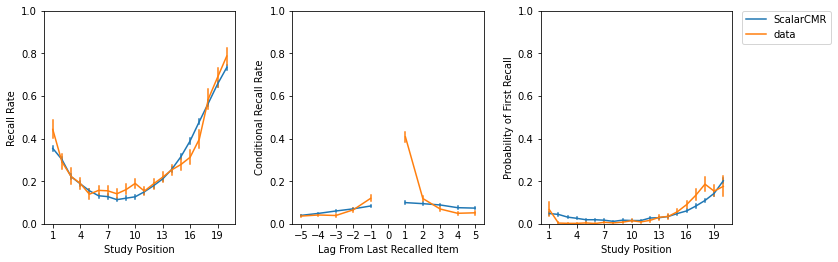

In [ ]:
fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(murdock_result.x)):
    fitted_parameters[free_parameters[i]] = murdock_result.x[i]
fitted_parameters['sampling_rule'] = 0

model0 = Scalar_CMR(20, 20, fitted_parameters)

sim_df0 = simulate_df(model0, 5000)
true_df0 = events

cmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['ScalarCMR', 'data'])
cmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['ScalarCMR', 'data'])
cmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['ScalarCMR', 'data'])
cmr_pfr0 = cmr_pfr0.query('output <= 1')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12/3), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, list_length+1, 3))
axes[0].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2], hue='source', legend=True)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, list_length+1, 3))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)